In [1]:
import os
if os.getcwd().replace("\\", "/").split("/")[-1] in ["notebooks", "scripts"]:
    os.chdir("..")


# the model

In [2]:
import duckdb
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
table = "sandbox_T_apartment_S_ca"
con = duckdb.connect("data/exploitation.db", read_only=True)

X_train = con.execute(f"select * from {table}_X_train_processed").df()
y_train = con.execute(f"select * from {table}_y_train_processed").df()
X_val = con.execute(f"select * from {table}_X_test_processed").df()
y_val = con.execute(f"select * from {table}_y_test_processed").df()

con.close()

## model training

In [4]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [5]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred),4))
    print("MAPE: ", round(metrics.mean_absolute_percentage_error(y_true, y_pred),4))
    print("R2: ", round(metrics.r2_score(y_true, y_pred),4))

### option 1-1 - linear regression (without regularization)

In [6]:
reg = LinearRegression().fit(X_train, y_train)
yhat_train_lin = reg.predict(X_train)
yhat_val_lin = reg.predict(X_val)

In [7]:
printMetrics(y_train, yhat_train_lin)
print()
printMetrics(y_val, yhat_val_lin)

RMSE:  0.1995
MAE:  0.1421
MAPE:  0.0192
R2:  0.7123

RMSE:  0.2026
MAE:  0.1431
MAPE:  0.0194
R2:  0.705


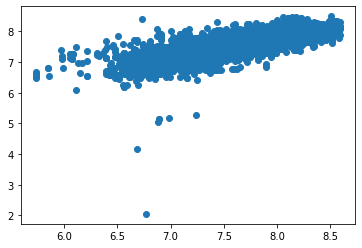

In [8]:
plt.scatter(y_train, yhat_train_lin)

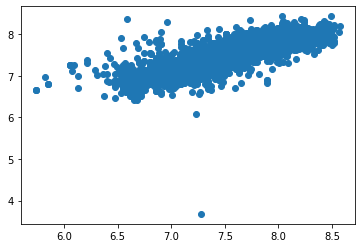

In [9]:
plt.scatter(y_val, yhat_val_lin)

### option 1-2 - ridge regression
it uses leave-one-out cross-validation to tune the regularization parameter

In [10]:
rreg = RidgeCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [11]:
rreg.score(X_train, y_train)

0.6829598489949549

In [12]:
yhat_train_rr = rreg.predict(X_train)
yhat_val_rr = rreg.predict(X_val)

In [13]:
rreg.get_params()

{'alpha_per_target': False,
 'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': 'deprecated',
 'scoring': None,
 'store_cv_values': False}

In [14]:
rreg.alpha_

1.0

In [15]:
printMetrics(y_train, yhat_train_rr)
print()
printMetrics(y_val, yhat_val_rr)

RMSE:  0.2094
MAE:  0.1542
MAPE:  0.0209
R2:  0.683

RMSE:  0.2129
MAE:  0.156
MAPE:  0.0211
R2:  0.6744


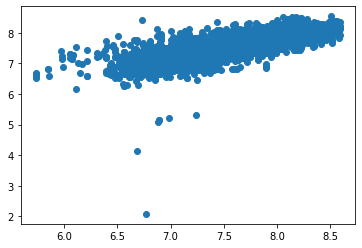

In [16]:
plt.scatter(y_train, yhat_train_rr)

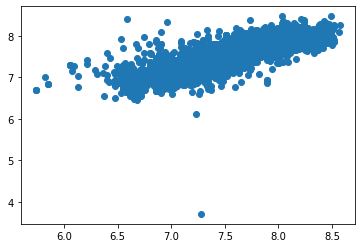

In [17]:
plt.scatter(y_val, yhat_val_rr)

### option 1-3 - lasso regression

In [18]:
lreg = LassoCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

/home/eloi/anaconda3/envs/ADSDB/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/eloi/anaconda3/envs/ADSDB/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.5997535349738, tolerance: 0.2091325853468251
  model = cd_fast.enet_coordinate_descent_gram(
/home/eloi/anaconda3/envs/ADSDB/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339.74897475087073, tolerance: 0.20835762088607562
  model = cd_fast.enet_coordinate_descent_gram(
/home/eloi/anaconda3/envs/ADSDB/lib/python3.10/site-pack

In [19]:
lreg.score(X_train, y_train)

0.7020643116381364

In [20]:
yhat_train_lr = lreg.predict(X_train)
yhat_val_lr = lreg.predict(X_val)

In [21]:
lreg.get_params()

{'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [22]:
lreg.alpha_

0.001

In [23]:
printMetrics(y_train, yhat_train_lr)
print()
printMetrics(y_val, yhat_val_lr)

RMSE:  0.203
MAE:  0.1437
MAPE:  0.0194
R2:  0.7021

RMSE:  0.2057
MAE:  0.1443
MAPE:  0.0195
R2:  0.6961


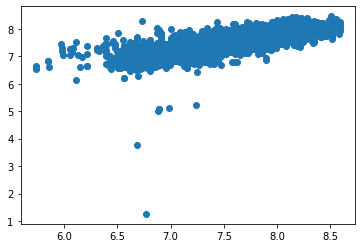

In [24]:
plt.scatter(y_train, yhat_train_lr)

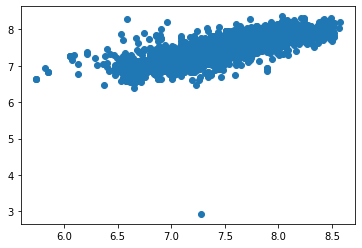

In [25]:
plt.scatter(y_val, yhat_val_lr)

### option 2 - random forest
random forest from scikit-learn library, with the default parameters

In [26]:
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)

/tmp/ipykernel_10046/1047091557.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)


In [27]:
yhat_train_rf = rf.predict(X_train)
yhat_val_rf = rf.predict(X_val)

In [28]:
printMetrics(y_train, yhat_train_rf)
print()
printMetrics(y_val, yhat_val_rf)

RMSE:  0.0429
MAE:  0.0212
MAPE:  0.0029
R2:  0.9867

RMSE:  0.0987
MAE:  0.0462
MAPE:  0.0062
R2:  0.93


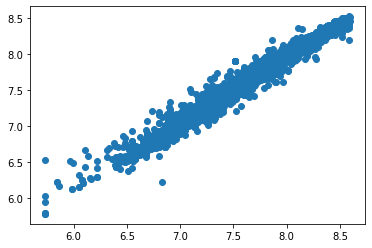

In [29]:
plt.scatter(y_train, yhat_train_rf)

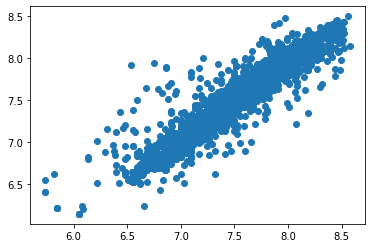

In [30]:
plt.scatter(y_val, yhat_val_rf)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

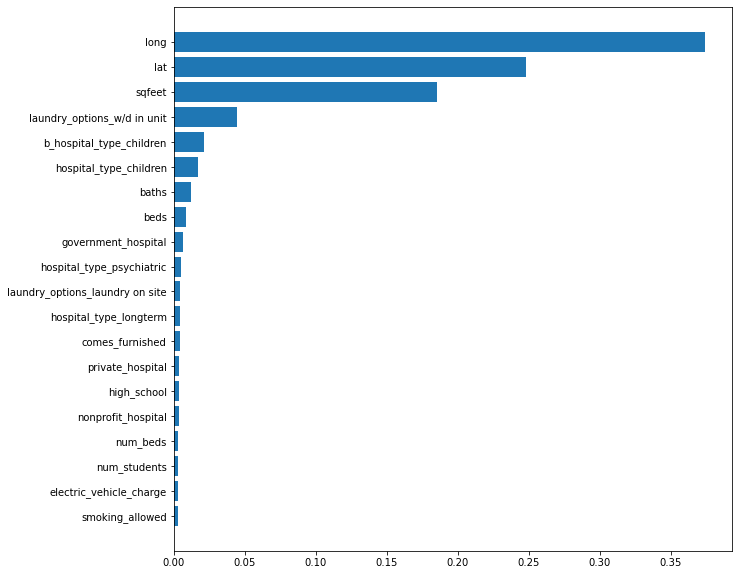

In [31]:
# top 20 feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(rf.feature_names_in_[sorted_idx][-20:], rf.feature_importances_[sorted_idx][-20:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [32]:
from sklearn.tree import plot_tree

[Text(0.5, 0.875, 'lat <= 34.472\nsquared_error = 0.138\nsamples = 11957\nvalue = 7.432'),
 Text(0.25, 0.625, 'sqfeet <= 6.842\nsquared_error = 0.092\nsamples = 5240\nvalue = 7.588'),
 Text(0.125, 0.375, 'long <= -117.015\nsquared_error = 0.069\nsamples = 3183\nvalue = 7.472'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'long <= -116.981\nsquared_error = 0.074\nsamples = 2057\nvalue = 7.765'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'long <= -121.828\nsquared_error = 0.14\nsamples = 6717\nvalue = 7.311'),
 Text(0.625, 0.375, 'lat <= 38.781\nsquared_error = 0.155\nsamples = 1234\nvalue = 7.782'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'laundry_options_w/d in unit <= 0.5\nsquared_error = 0.074\nsamples = 5483\nvalue = 7.202'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

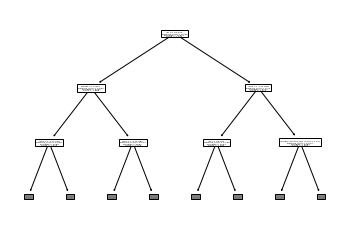

In [33]:
# plot of one of the trees of the random forest
# cut at 2 levels, for visualization
plot_tree(rf.estimators_[0], max_depth=2, feature_names=rf.feature_names_in_)

### option 3 - xgboost

#### without hyperparameter tunning

In [34]:
#!pip install -U xgboost --quiet

In [35]:
import xgboost as xgb

In [36]:
param = {
    'objective':'reg:squarederror',
    'verbosity':1,
    'learning_rate':0.3,
    'max_depth':10,
    'subsample':0.8, # to avoid overfitting
    'reg_lambda':0.1, # L2 reg
    'alpha':0, #L1 reg
    'max_leaves':10
}
n_estim = 20

In [37]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_val = xgb.DMatrix(X_val, label=y_val)

In [38]:
time0 = time()
xgb_1 = xgb.train(param, data_train, n_estim)
print(time()-time0)

0.562814474105835


In [39]:
yhat_train_xgb1 = xgb_1.predict(data_train)
yhat_val_xgb1 = xgb_1.predict(data_val)

In [40]:
printMetrics(y_train, yhat_train_xgb1)
print()
printMetrics(y_val, yhat_val_xgb1)

RMSE:  0.0612
MAE:  0.0424
MAPE:  0.0057
R2:  0.9729

RMSE:  0.1097
MAE:  0.0618
MAPE:  0.0083
R2:  0.9136


In [41]:
from xgboost import plot_importance, plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

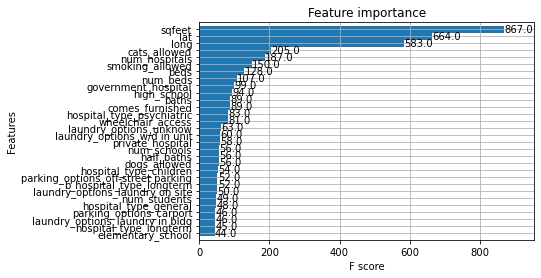

In [42]:
plot_importance(xgb_1, max_num_features = 30, height = 1)

In [43]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

ImportError: You must install graphviz to plot tree

<Figure size 720x720 with 0 Axes>

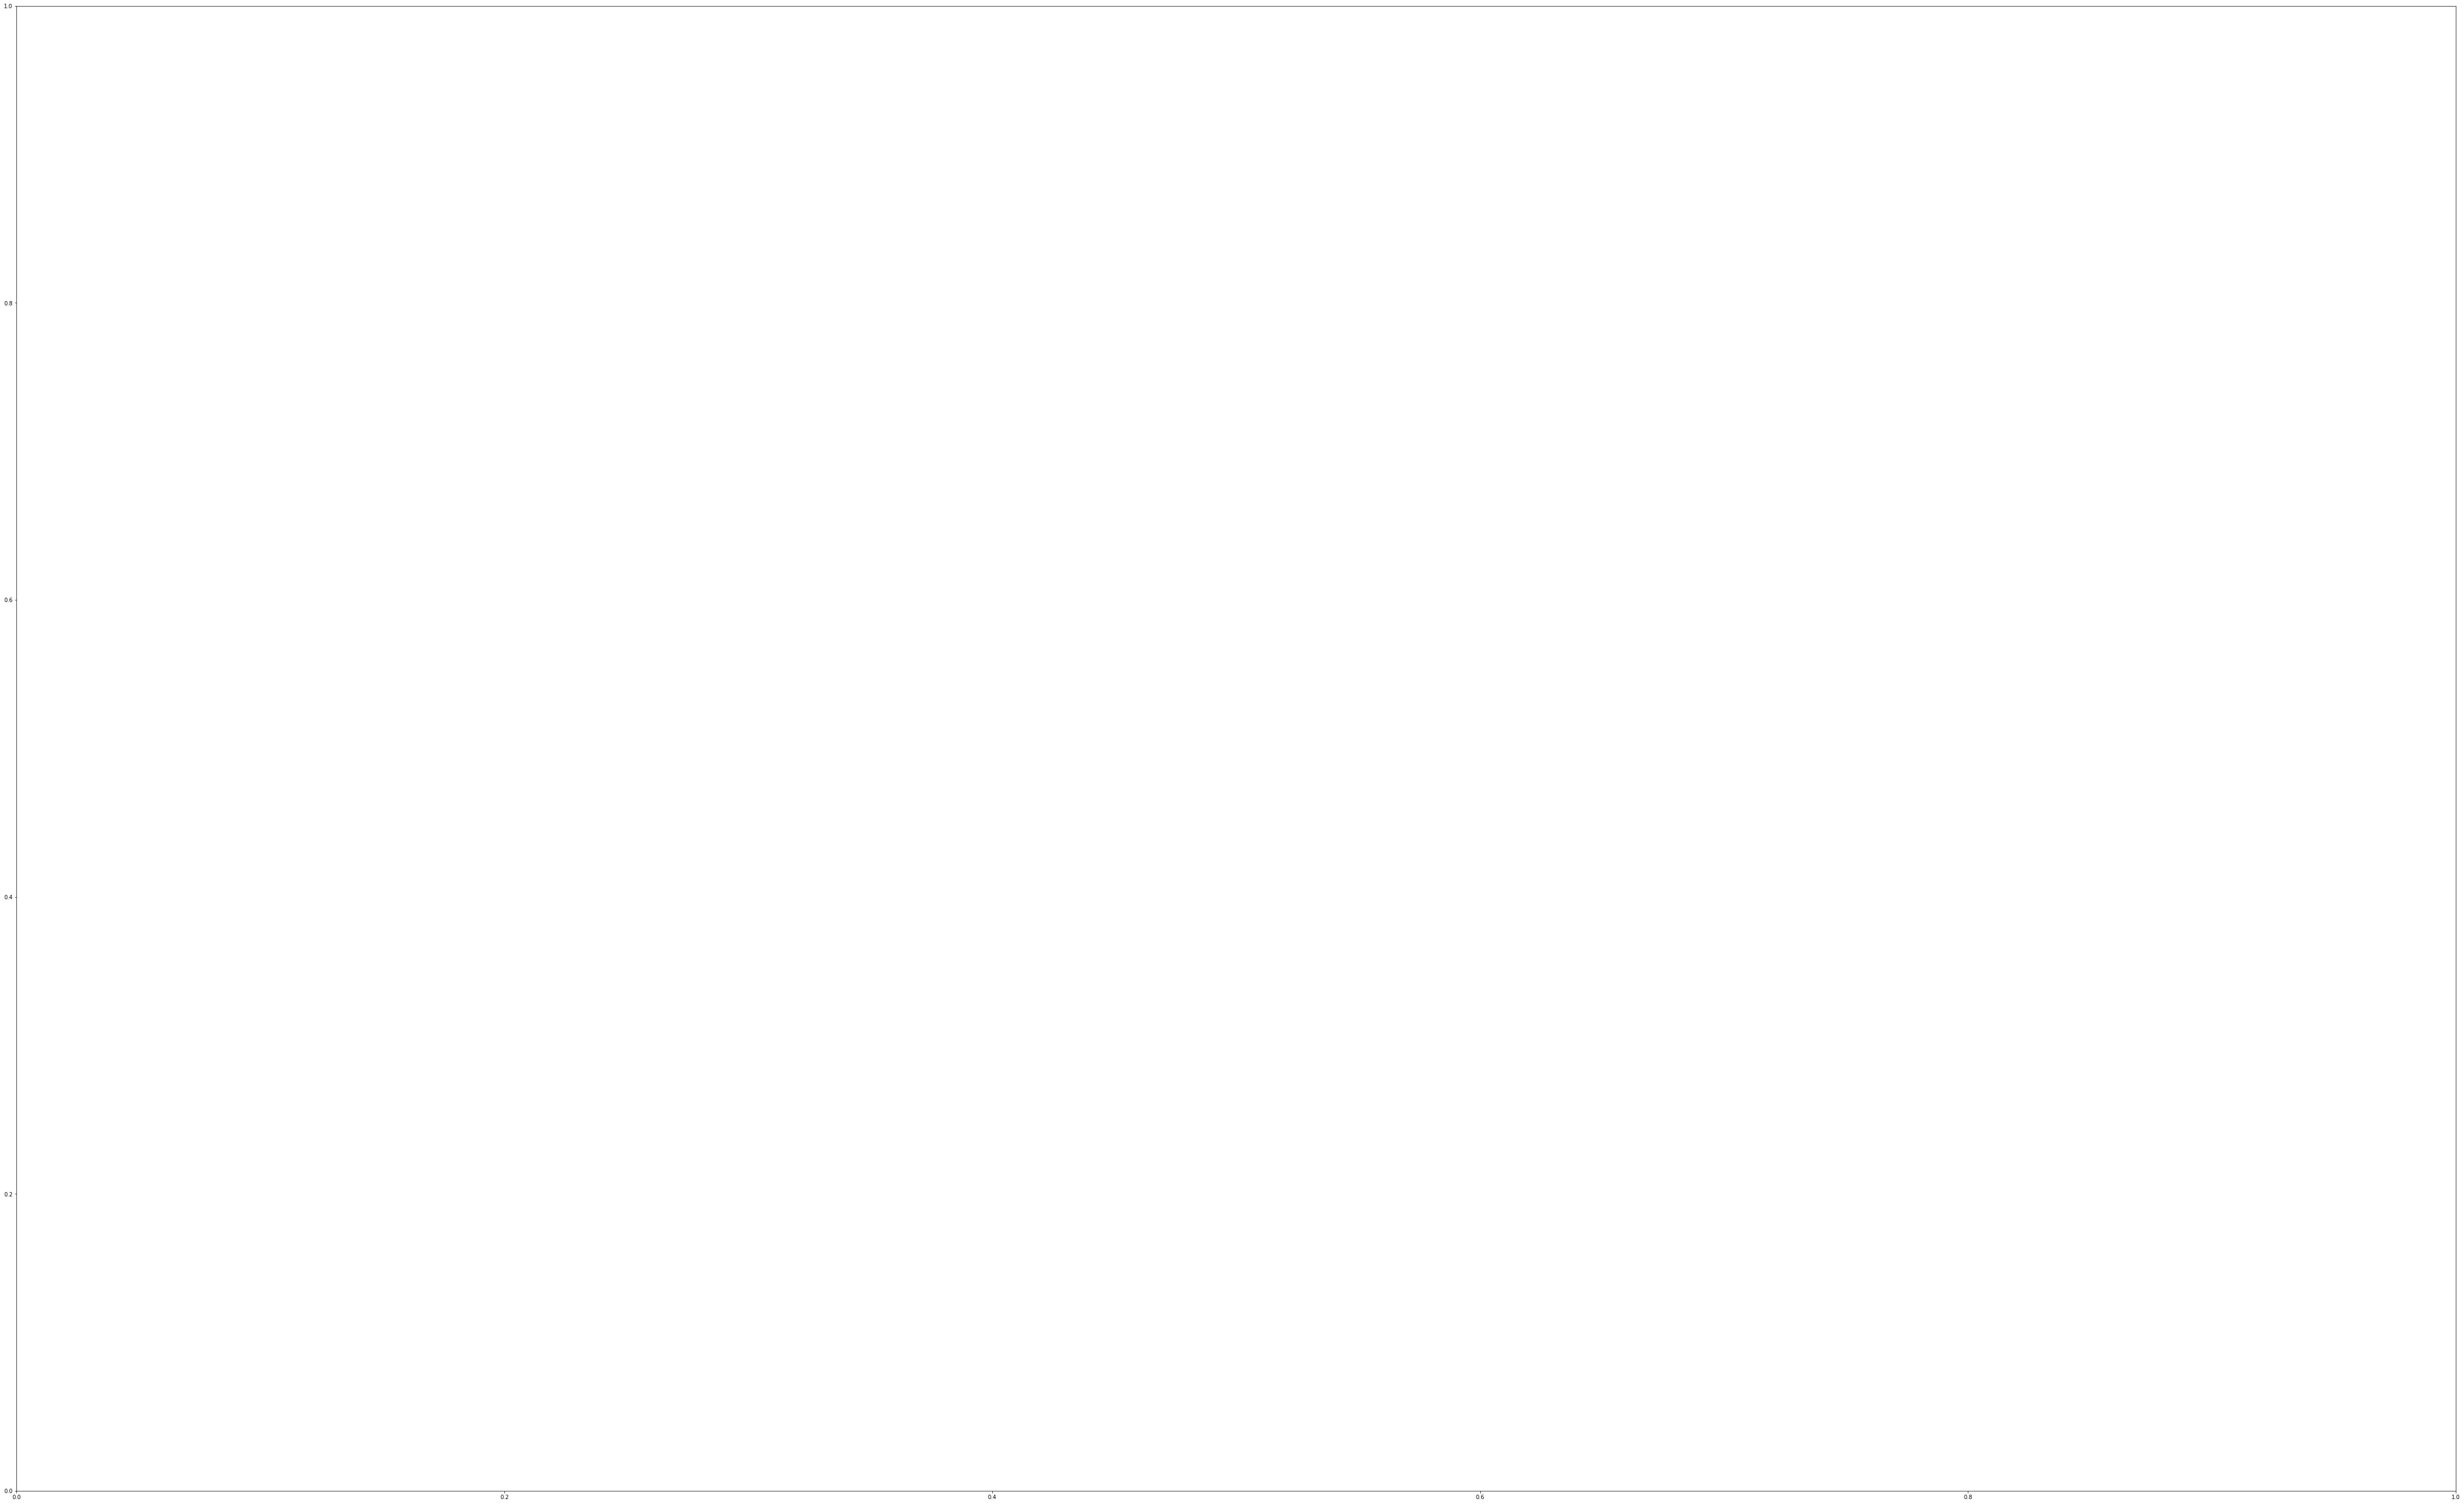

In [44]:
plt.figure(figsize=(10,10))
xgb.plot_tree(xgb_1, num_trees = 4, rankdir="LR")

In [ ]:
# if the previous cell (plot_tree) doesn't work, install graphviz from here and add it to the path:

#https://graphviz.org/download/
#import os
#os.environ["PATH"] += os.pathsep+'C:/Program Files (x86)/Graphviz/bin'

#### with hyperparameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    #'objective':'reg:squarederror',
    #'verbosity':1,
    'learning_rate':[0.1, 0.3, 1],
    'max_depth':[5, 7, 10],
    'subsample':[0.8], # to avoid overfitting
    'reg_lambda':[0, 0.1, 1], # L2 reg
    'alpha':[0, 0.1, 1], #L1 reg
    'max_leaves':[10],
    'n_estimators':[5, 10, 20]
}


In [ ]:
xgbr = xgb.XGBRegressor(seed = 20, objective = 'reg:squarederror', verbosity = 1)

time0 = time()
xgb_grid = GridSearchCV(estimator=xgbr, param_grid = params, cv = 3)
xgb_grid.fit(X_train, y_train)
# retrain with the best parameters:
xgb_cv = xgb.train(xgb_grid.best_params_, data_train, xgb_grid.best_params_['n_estimators'])

print(time()-time0) # time ~ 443s

[22:31:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

312.82209610939026


In [ ]:
"""{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0.1,
 'subsample': 0.8}"""
xgb_grid.best_params_

{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0.1,
 'subsample': 0.8}

In [ ]:
yhat_train_xgbcv = xgb_cv.predict(data_train)
yhat_val_xgbcv = xgb_cv.predict(data_val)

In [ ]:
printMetrics(y_train, yhat_train_xgbcv)
print("")
printMetrics(y_val, yhat_val_xgbcv)

RMSE:  0.0581
MAE:  0.0407
MAPE:  0.0055
R2:  0.9752

RMSE:  0.0802
MAE:  0.0488
MAPE:  0.0065
R2:  0.9522


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

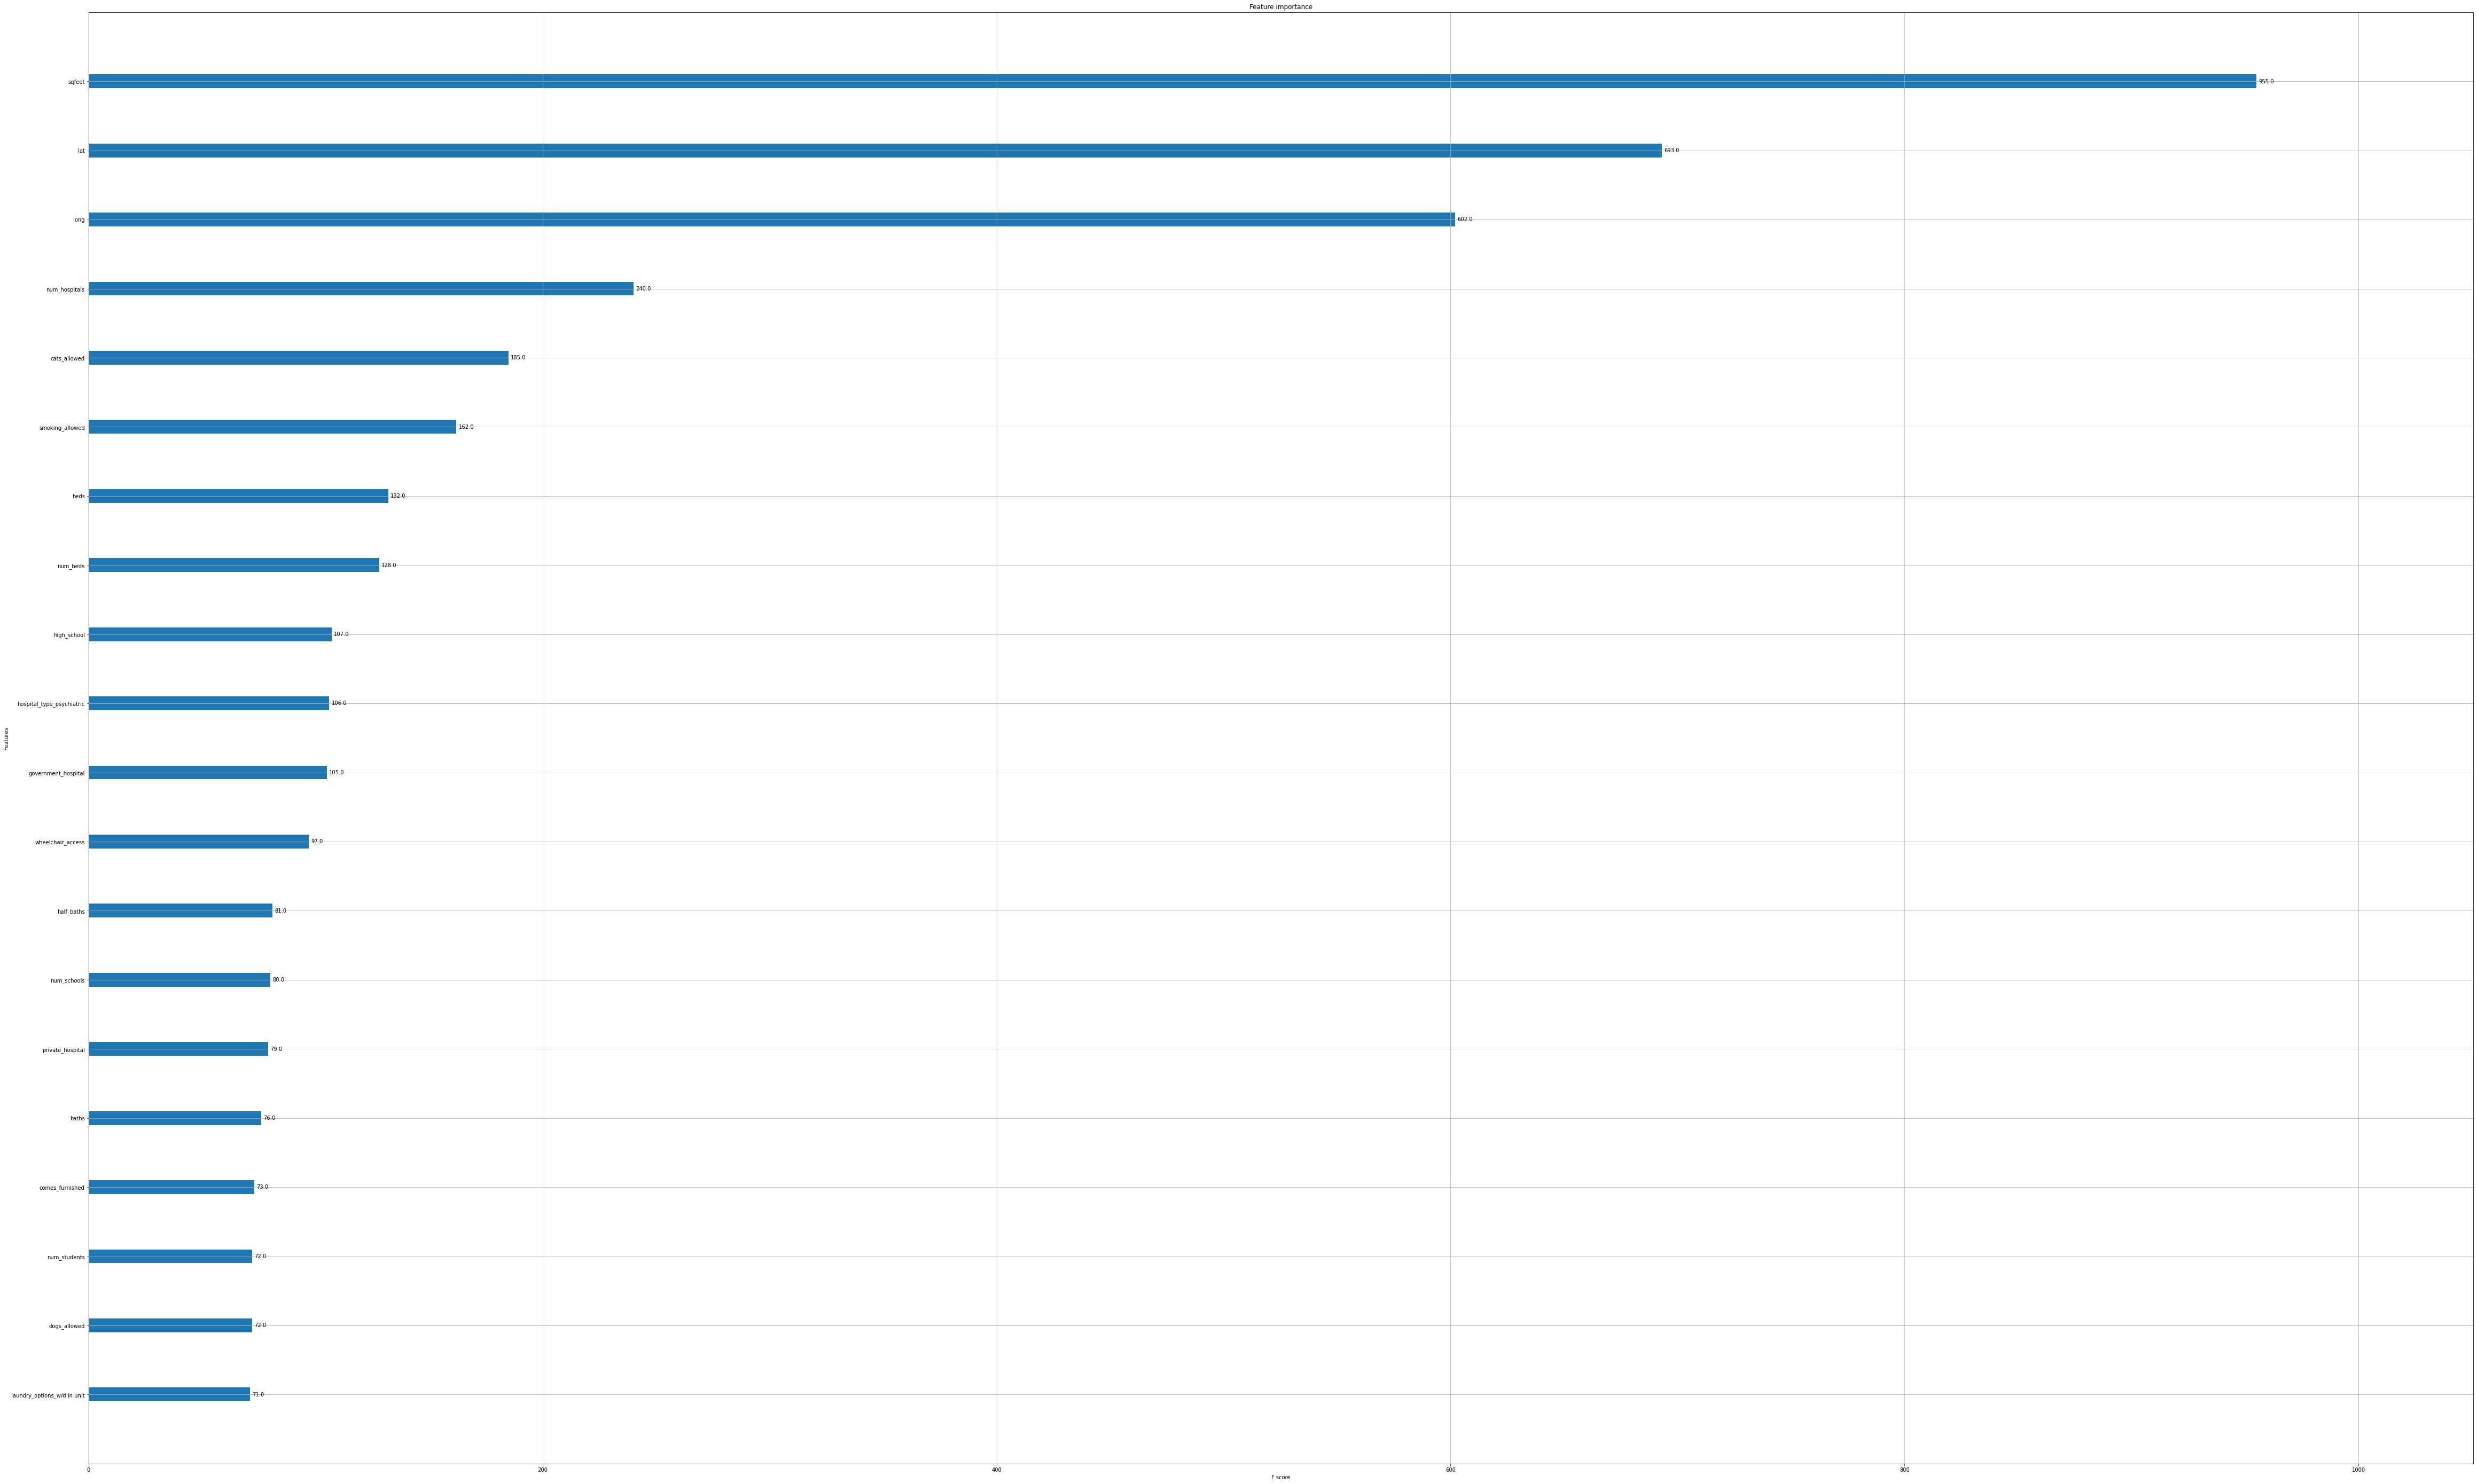

In [ ]:
plot_importance(xgb_cv, max_num_features=20)

# plots

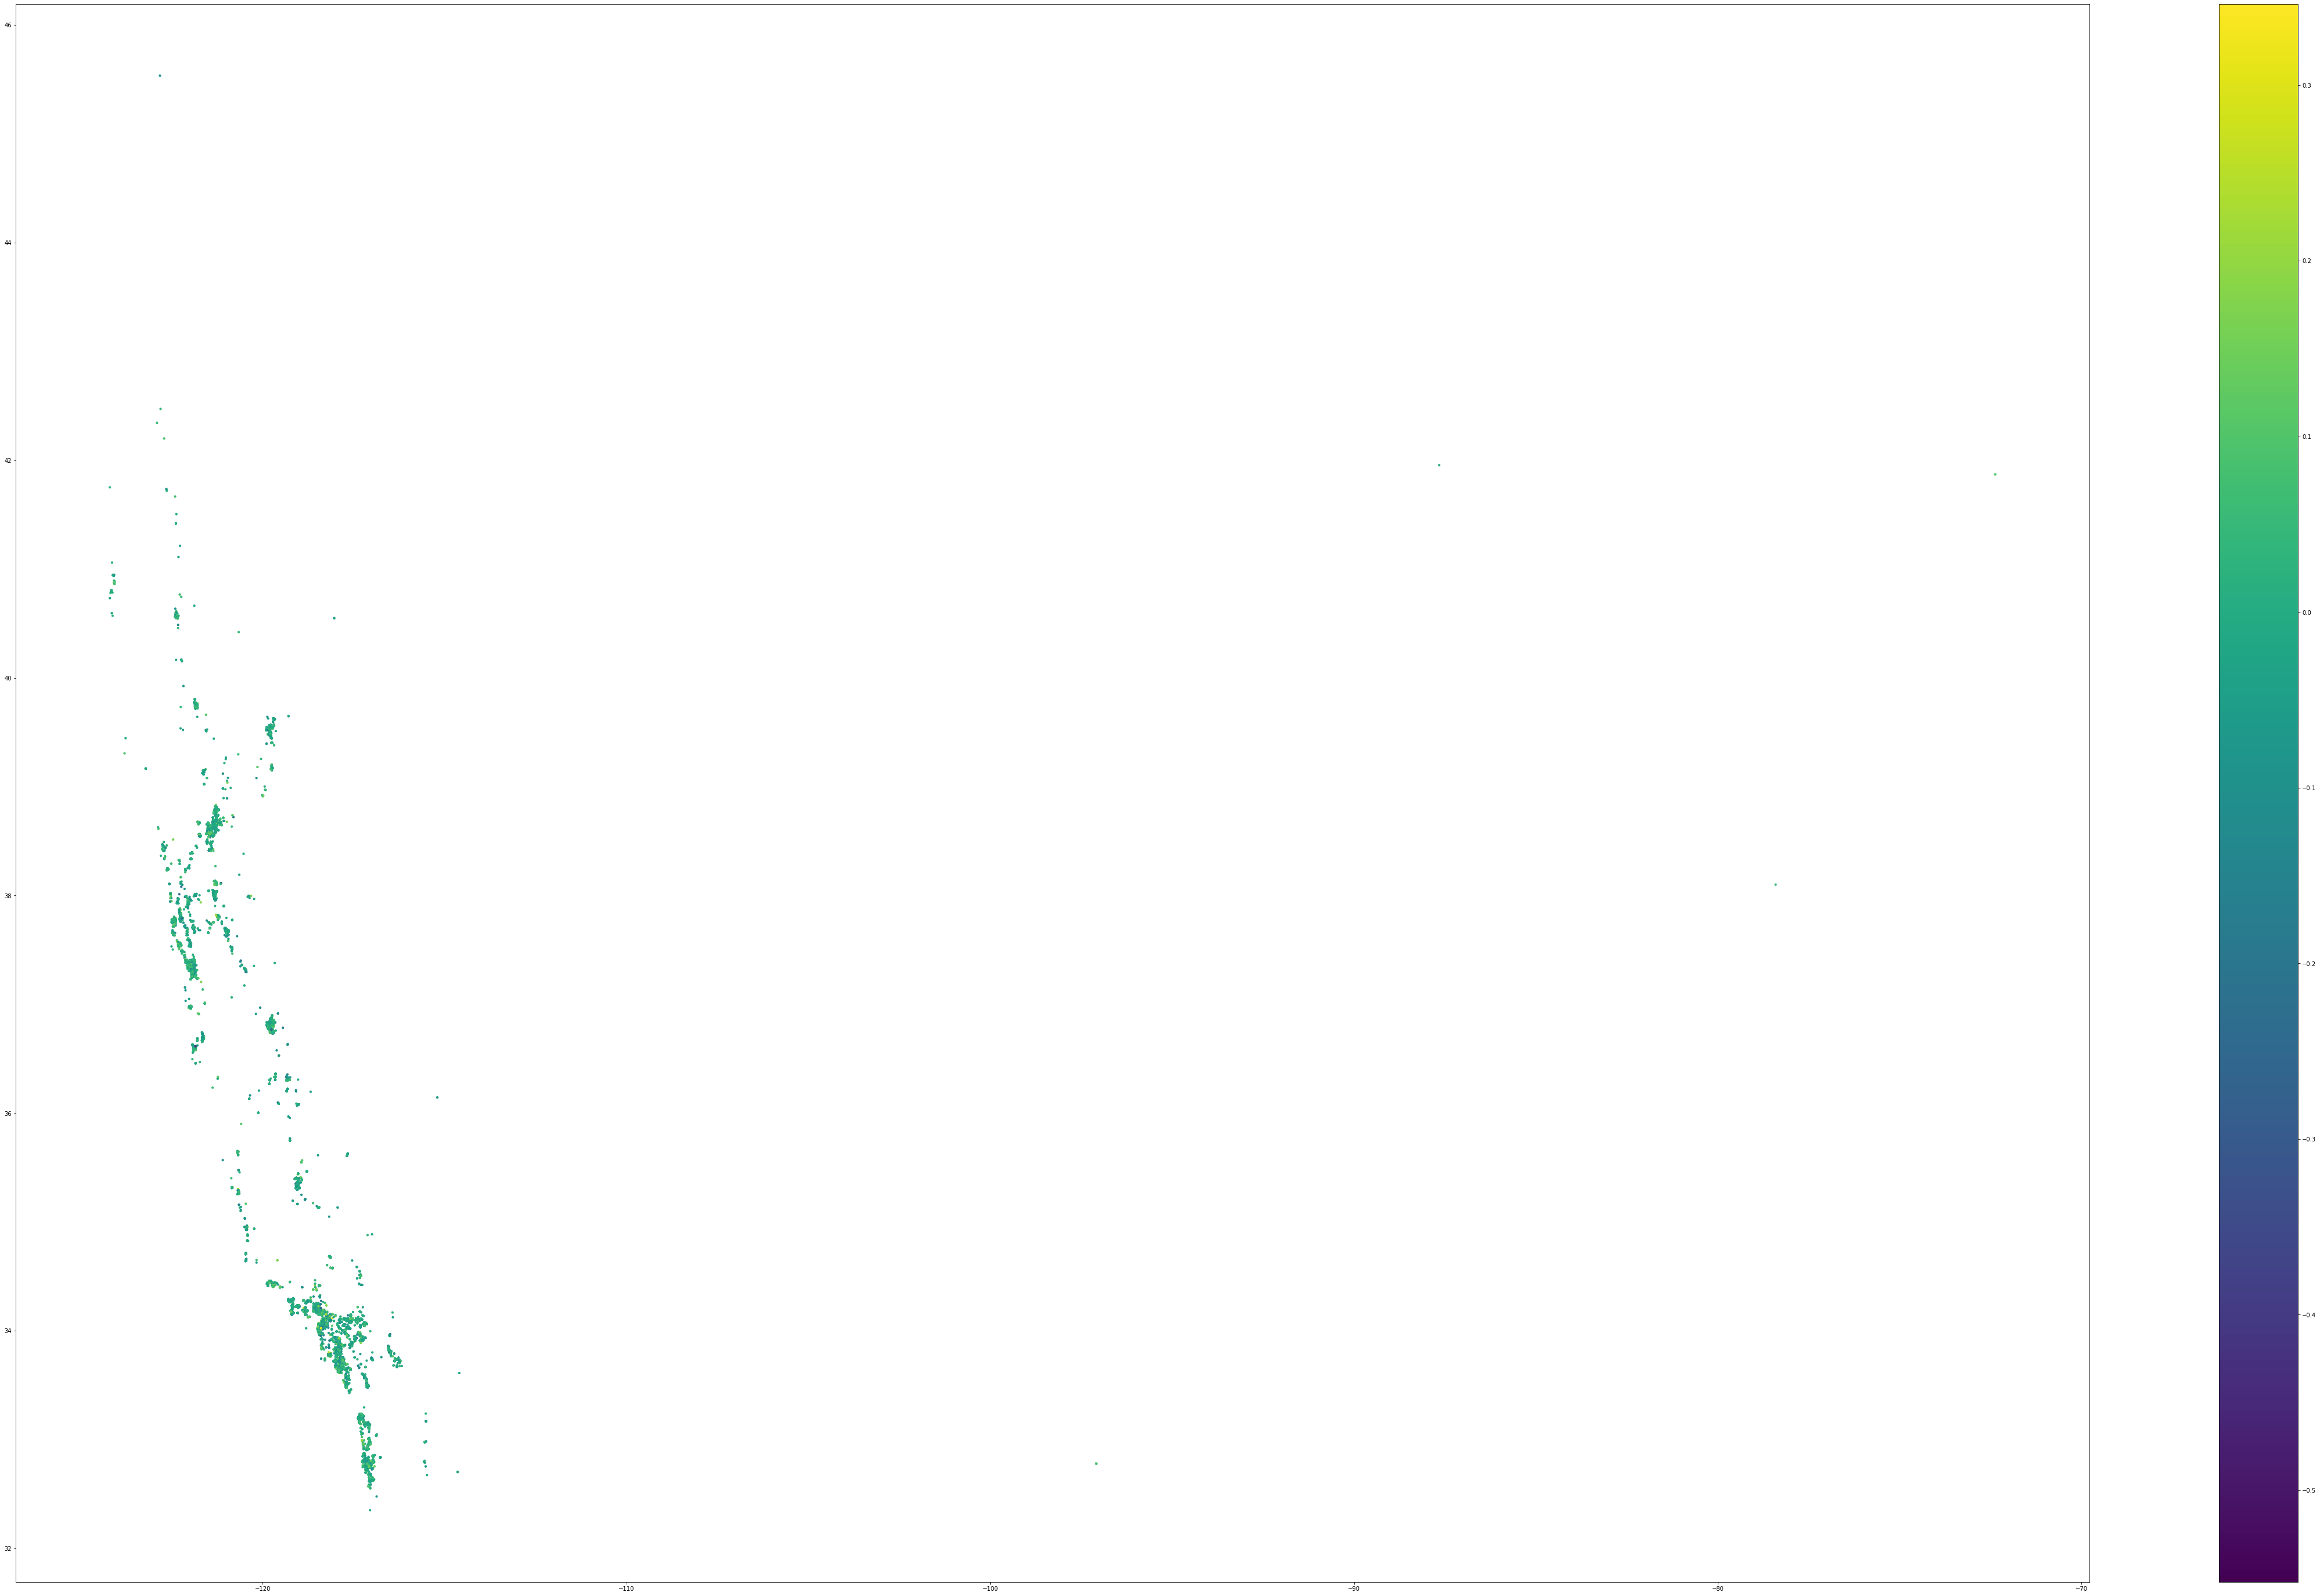

In [ ]:
plt.scatter(X_train.long, X_train.lat, c=y_train-yhat_train_xgbcv, s=10)
plt.colorbar()

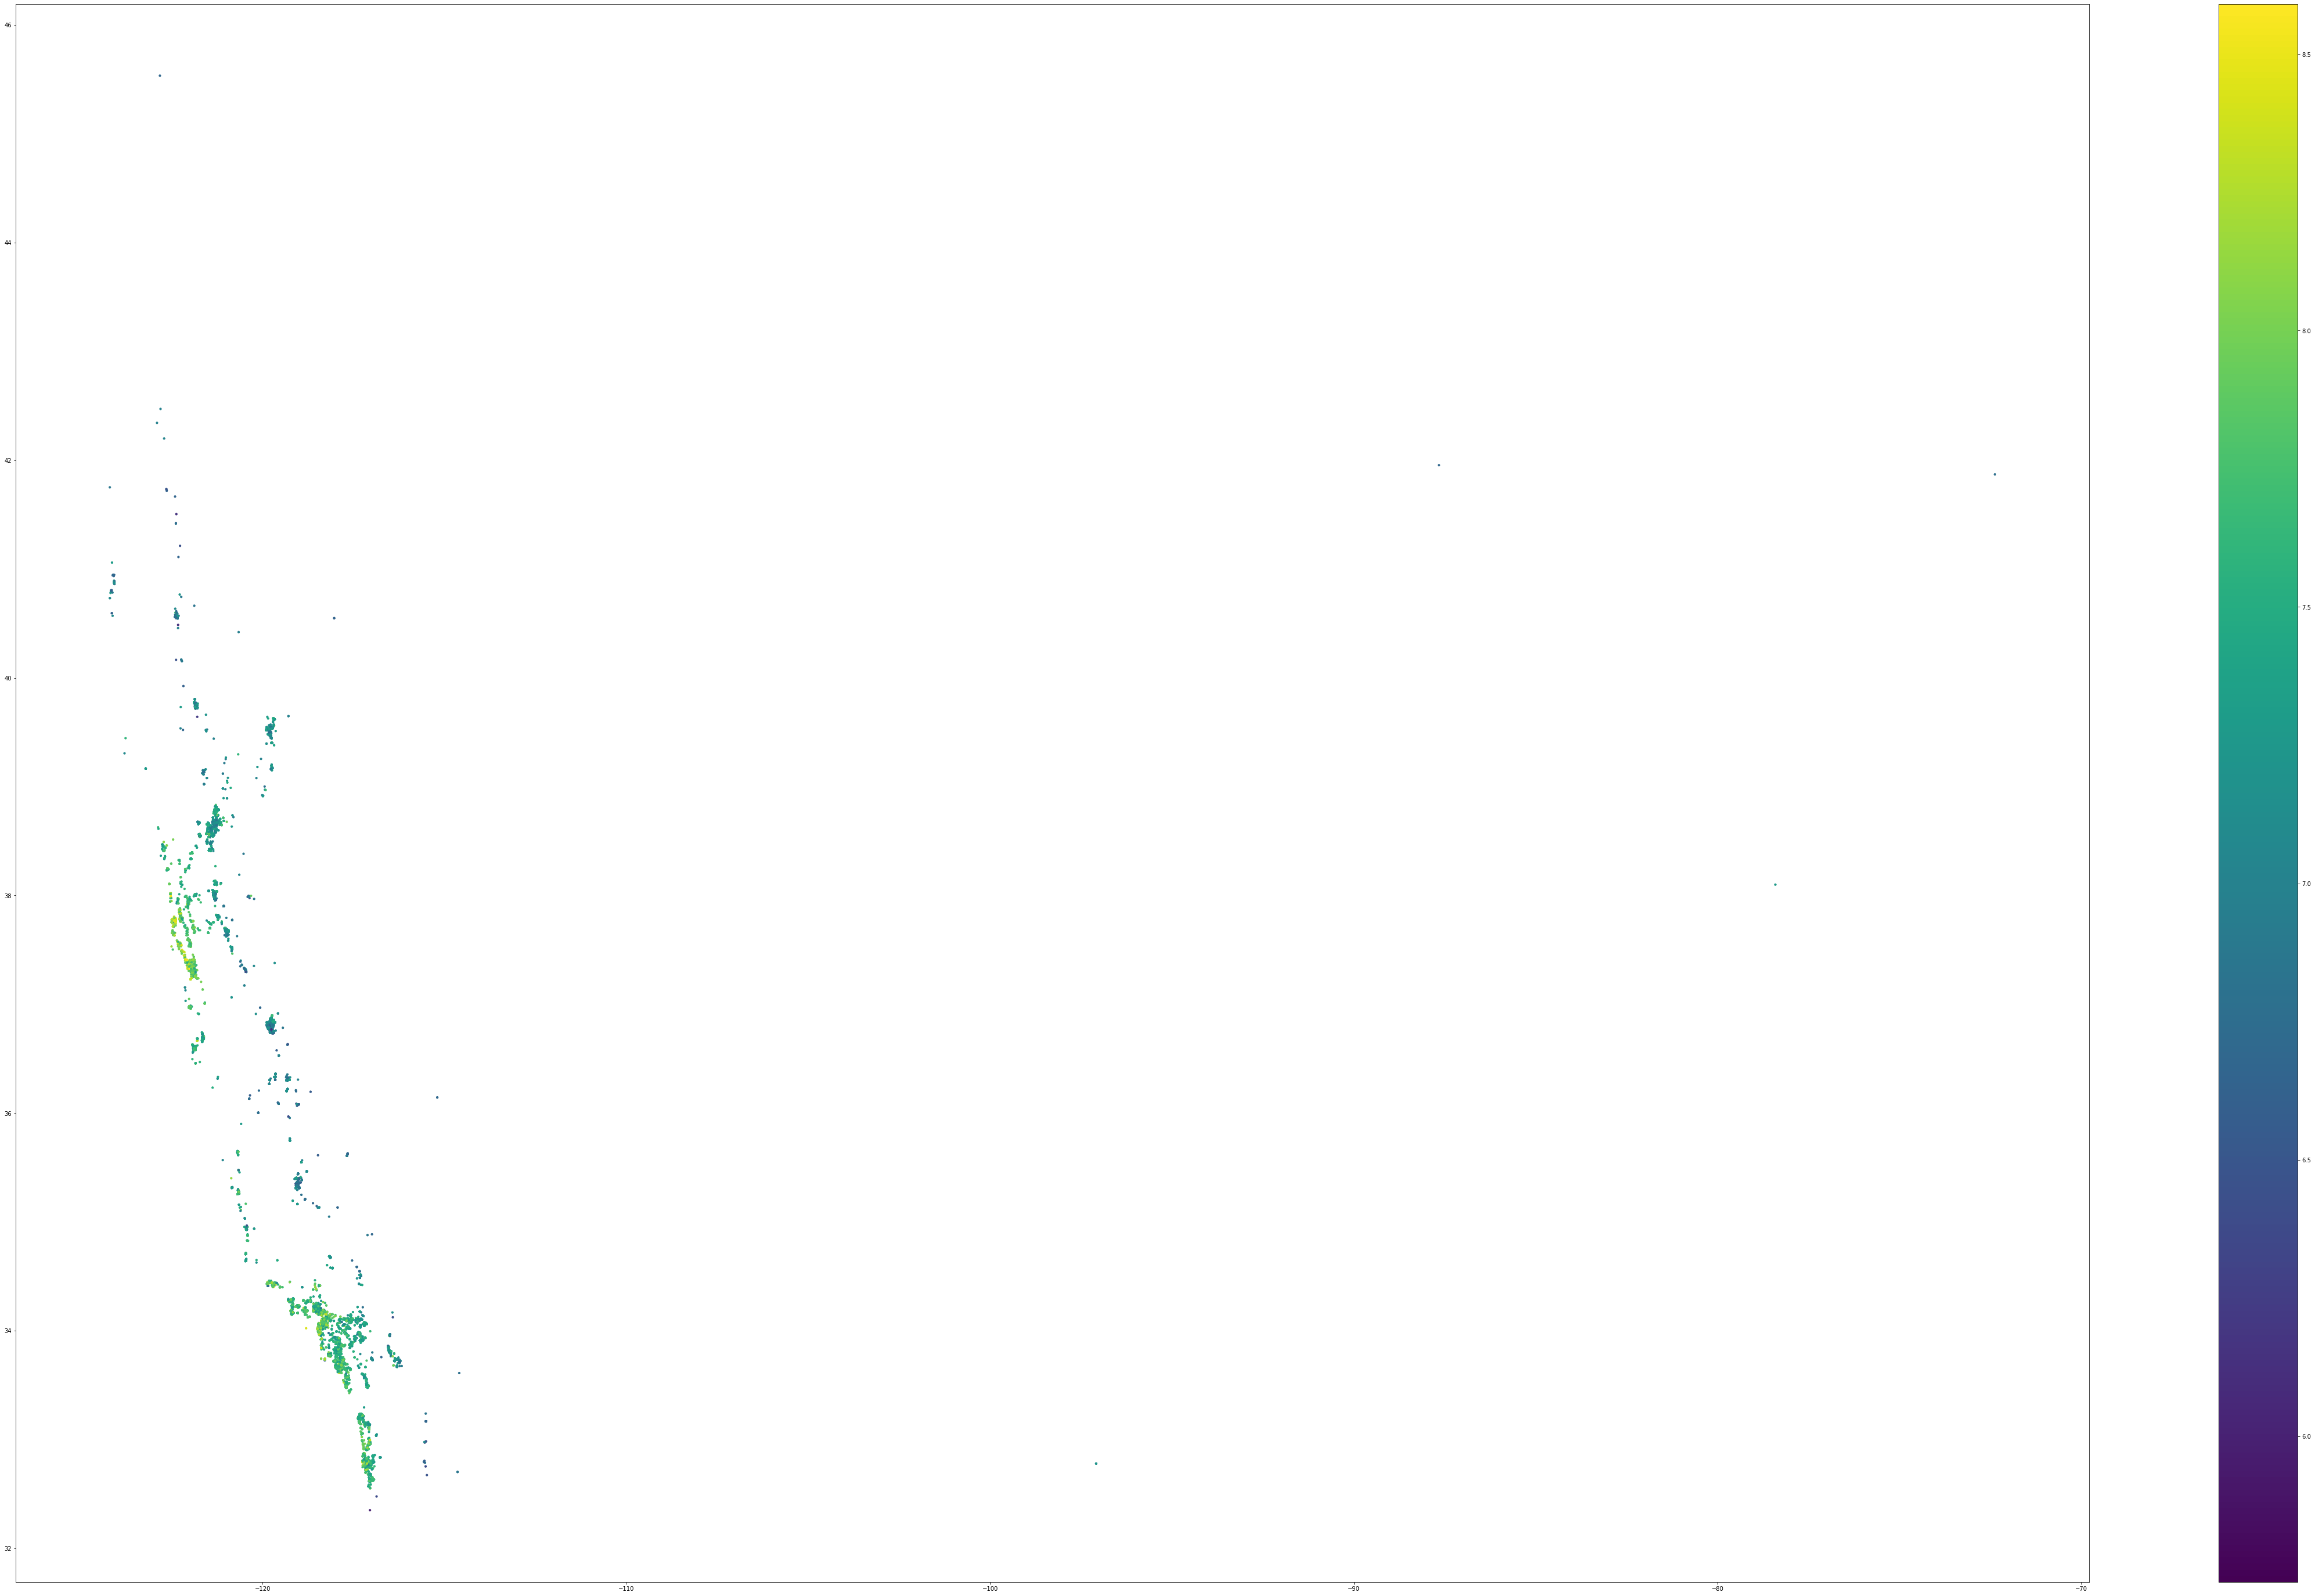

In [ ]:
plt.scatter(X_train.long, X_train.lat, c=y_train, s=10)
plt.colorbar()